### Starting cell

In [1]:
#starting cell ~4 min to process

#dataframes:
#df - raw home events
#home_sessions - clusters of home events
#resets - demo accs and operations data for MDT and MPS, with markesr for activity in 2022 or summer of 2022
#with subsets as resets2022 and resets_summer
#home_sessions_templates - long clusters of home events with demo acc data for final analysis


# root folder C:/Users/SergeyRyzhov/
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
import random
plt.style.use('fivethirtyeight')
df = pd.read_csv('C:/Users/SergeyRyzhov/Downloads/BQ data/demo_home_events.csv')
df.sort_values(by = ['Account','HomeEventDatetime'], inplace = True)
df['HomeEventDatetime'] = pd.to_datetime(df['HomeEventDatetime'])
df.drop_duplicates(subset = ['HomeEventDatetime'],inplace = True)
df.drop(df[df['Account']==5].index, inplace = True)
df.reset_index(drop = True, inplace = True)
#calculate time deltas between same acc same user home events
for index,row in df.iterrows():
    if index > 0:
        if (row['Account'] == (df.loc[(index-1)])['Account']) & (row['HomeUserID'] == (df.loc[(index-1)])['HomeUserID']):
            this_time = row['HomeEventDatetime']
            previous_time = (df.loc[(index-1)])['HomeEventDatetime']
            df.at[index, 'TimeDelta'] = this_time - previous_time

# mapping out session borders
home_sessions = pd.DataFrame() #empty df for sessions

#time delta cutoff
session_border = 25
session_id = 0

for row in df.itertuples():
    index = row[0]
    delay = df.loc[(index)]['TimeDelta'] / pd.Timedelta(minutes = 1)
    if index == 0: #first row exception
        session_username = row[1] + ' ' + row [2]
        session_accid = row[3]
        session_uid = row[4]
        session_start = row[5]
        session_count = 1
    else:
        if (delay < session_border) | (df.loc[(index)]['TimeDelta'] == None): #session continues
            session_count += 1
        else: #session ends
            session_end = df.loc[(index-1)]['HomeEventDatetime']
            #record session data into df
            home_sessions.at [session_id, 'Username'] = session_username
            home_sessions.at [session_id, 'UserID'] = session_uid
            home_sessions.at [session_id, 'AccountID'] = session_accid
            home_sessions.at [session_id, 'SessionStart'] = session_start
            home_sessions.at [session_id, 'SessionEnd'] = session_end
            home_sessions.at [session_id, 'SessionCount'] = session_count
            #start a new session
            session_id += 1
            session_username = row[1] + ' ' + row [2]
            session_accid = row[3]
            session_uid = row[4]
            session_start = row[5]
            session_count = 1

home_sessions['SessionLength'] = home_sessions['SessionEnd'] - home_sessions['SessionStart']
home_sessions['SessionLengthMinutes'] = home_sessions['SessionLength'] / pd.Timedelta(minutes = 1)
home_sessions['Session month'] = home_sessions['SessionStart'].dt.to_period('M')
home_sessions['Session week'] = home_sessions['SessionStart'].dt.to_period('W')

#extract account info to merge with demo acc stats
resets = pd.read_csv("C:/Users/SergeyRyzhov/Downloads/JNB/demo_acc_resets_wrangled.csv")
resets['Datetime']=pd.to_datetime(resets['Datetime'])
resets['Operation month'] = resets['Datetime'].dt.to_period('M')
resets['Operation year']=resets['Datetime'].dt.year
resets['CreatedOn']=pd.to_datetime(resets['CreatedOn'])
resets['Created year']=resets['CreatedOn'].dt.year
resets['Created month'] = resets['CreatedOn'].dt.to_period('M')
resets.drop(['AccountID'], axis = 1, inplace = True)
#check if the owner performed the operation
resets['SelfService'] = False
resets['SelfService'].mask((resets['DemoOwner'] == resets['ResetterID']),True,inplace = True)

active_accs = home_sessions.loc[home_sessions['SessionLengthMinutes']>20,'AccountID']
active_accs = active_accs.to_frame()
active_accs = active_accs.assign(ActiveIn2022 = True)
active_accs.drop_duplicates(inplace = True)

active_accs_summer = home_sessions.loc[(home_sessions['SessionLengthMinutes']>20) & (home_sessions['SessionStart'] > '2022-05-31'),'AccountID']
active_accs_summer = active_accs_summer.to_frame()
active_accs_summer = active_accs_summer.assign(ActiveThisSummer = True)
active_accs_summer.drop_duplicates(inplace = True)
active_accs_summer

resets = resets.merge(active_accs, how = 'left', left_on='Account',right_on='AccountID')
resets.drop('AccountID', axis = 1, inplace = True)
resets = resets.merge(active_accs_summer, how = 'left', left_on='Account',right_on='AccountID')
resets.drop('AccountID', axis = 1, inplace = True)
resets[['ActiveIn2022','ActiveThisSummer']] = resets[['ActiveIn2022','ActiveThisSummer']].fillna(False)

resets2022 = resets.loc[resets['ActiveIn2022'] == True]
resets_summer = resets.loc[resets['ActiveThisSummer'] == True]

resets_to_sessions = resets2022[['Account','Owner Name','Template','Created month']]
home_sessions = home_sessions.merge(resets_to_sessions, how = 'left', left_on = 'AccountID', right_on = 'Account')
home_sessions_demo = home_sessions[['AccountID','Username','SessionStart','SessionCount','SessionLengthMinutes', 'Template','Owner Name', 'Session month', 'Session week', 'Created month',]]
home_sessions_demo = home_sessions_demo.loc[home_sessions_demo['SessionLengthMinutes']>20]
home_sessions_demo.drop_duplicates(inplace = True)
home_sessions_demo.reset_index(drop = True, inplace = True)
home_sessions_demo = home_sessions_demo.loc[home_sessions_demo['Session month']<'2022-09']
home_sessions_demo['Template'].fillna('Other', inplace = True)
home_sessions_demo['Owner Name'].fillna('Unknown', inplace = True)
home_sessions_demo['Created month'].fillna('Unknown', inplace = True)

resets_peracc = resets.groupby(['Account','operation_type'])['OperationID'].count()
resets_peracc = resets_peracc.unstack(level=-1)
resets_peracc.drop(['Create account'], axis = 1, inplace = True)
resets_peracc.fillna(0, inplace = True)
resets_peracc.reset_index(inplace = True)
resets_peracc.drop([0], axis = 0, inplace = True)
resets_peracc

home_sessions_demo = home_sessions_demo.merge(resets_peracc, how = 'left', left_on = 'AccountID', right_on = 'Account')
home_sessions_demo['Reset dates'].fillna(0, inplace = True)
home_sessions_demo['Reset to zero'].fillna(0, inplace = True)
home_sessions_demo.sort_values(by = ['Owner Name','SessionStart'], inplace = True)
home_sessions_demo[['Never reset dates','Never reset to zero','Reset nothing']] = False
home_sessions_demo['Never reset dates'].mask(home_sessions_demo['Reset dates']==0, True, inplace = True)
home_sessions_demo['Never reset to zero'].mask(home_sessions_demo['Reset to zero']==0, True, inplace = True)
home_sessions_demo['Reset nothing'].mask(((home_sessions_demo['Reset dates']==0) & (home_sessions_demo['Reset to zero']==0)), True, inplace = True)
# counts of accounts with no resets by month of creation
active_accs_resets = home_sessions_demo[['AccountID','Template','Created month','Never reset dates','Never reset to zero','Reset nothing']]
active_accs_resets.drop_duplicates(subset = 'AccountID', inplace = True)
active_accs_resets = active_accs_resets.loc[active_accs_resets['Created month']!='Unknown']
active_accs_creation_count = active_accs_resets.groupby(['Created month','Template'], as_index = False)['AccountID'].count()
active_accs_creation_count.rename(columns = {'AccountID':'Created total'},inplace = True)

active_accs_no_reset = active_accs_resets.loc[active_accs_resets['Reset nothing']==True]
active_accs_no_reset = active_accs_no_reset[['AccountID','Created month','Template']]
active_accs_no_reset = active_accs_no_reset.groupby(['Created month','Template'], as_index = False)['AccountID'].count()
active_accs_no_reset.rename(columns = {'AccountID':'Never reset'},inplace = True)

active_accs_no_date_reset = active_accs_resets.loc[active_accs_resets['Never reset dates']==True]
active_accs_no_date_reset = active_accs_no_date_reset[['AccountID','Created month','Template']]
active_accs_no_date_reset = active_accs_no_date_reset.groupby(['Created month','Template'], as_index = False)['AccountID'].count()
active_accs_no_date_reset.rename(columns = {'AccountID':'Never reset dates'},inplace = True)

active_accs_no_zero_reset = active_accs_resets.loc[active_accs_resets['Never reset to zero']==True]
active_accs_no_zero_reset = active_accs_no_zero_reset[['AccountID','Created month','Template']]
active_accs_no_zero_reset = active_accs_no_zero_reset.groupby(['Created month','Template'], as_index = False)['AccountID'].count()
active_accs_no_zero_reset.rename(columns = {'AccountID':'Never reset to zero'},inplace = True)

active_accs_all_resets = active_accs_creation_count.merge(active_accs_no_reset, how = 'left').merge(active_accs_no_date_reset, how = 'left').merge(active_accs_no_zero_reset, how = 'left')
active_accs_all_resets.fillna(0, inplace = True)
active_accs_all_resets['Never reset dates'] = active_accs_all_resets['Never reset dates'] - active_accs_all_resets['Never reset']
active_accs_all_resets['Never reset to zero'] = active_accs_all_resets['Never reset to zero'] - active_accs_all_resets['Never reset']

active_accs_all_resets_mps = active_accs_all_resets.loc[active_accs_all_resets['Template']=='M&PS']
active_accs_all_resets_mdt = active_accs_all_resets.loc[active_accs_all_resets['Template']=='MDT']


### Chart cell

In [ ]:
#chart description
name = '.png'
plt.title('')

#plt.savefig(name, dpi = 300, bbox_inches = 'tight')
plt.show()

### Working section

In [ ]:
#histogram of timedelta
name = 'timedelta_hist.png'
plt.figure(figsize = (5,7))
plt.title('Time delta distribution')
plt.xlabel ('Delta in minutes')
plt.hist((df['TimeDelta'] / pd.Timedelta(minutes = 1)),range = (1,60),bins = 'doane', density = True)
plt.savefig(name, dpi = 300, bbox_inches = 'tight')
plt.show()

In [ ]:
#examining random chanks of df
start_position = random.randint(0,(len(df)))
end_position = start_position + 30
df.loc[start_position : end_position]

In [ ]:
#checking sessions
start_position = df.loc[df['HomeEventDatetime']=='2022-01-19 23:57:22.652'].index.values[0]
end_position = start_position + 30
df.loc[start_position : end_position]

In [ ]:
#home many events sessions have
name = 'session_count_hist.png'
plt.title('Count of Home events in a session')
plt.hist(home_sessions['SessionCount'], range = (5,45), density = True, bins = [5,10,15,20,25,30,35,40,45])
plt.xticks([5,10,15,20,25,30,35,40,45])
plt.savefig(name, dpi = 300, bbox_inches = 'tight')
plt.show()

In [ ]:
#home long sessions last
name = 'session_length_hist.png'
plt.title('Session length in minutes')
plt.xticks ([10,20,30,40,50,60,90,120])
plt.hist(home_sessions['SessionLengthMinutes'], range = (10,120), bins = [10,20,30,40,50,60,90,120], density = True)
plt.savefig(name, dpi = 300, bbox_inches = 'tight')
plt.show()

In [ ]:
#see how many sessions per user
user_counts = home_sessions.groupby(by = ['Username']).count()
user_counts.reset_index(inplace = True)
user_counts = user_counts[['Username','UserID']].sort_values(by = ['UserID'], ascending = False)
user_counts.rename(columns = {'UserID':'NoOfSessions'}, inplace = True)

In [ ]:
#
name = 'popular_users1.png'
top_15 = user_counts[:15]
top_15.sort_values(by = 'NoOfSessions', ascending = True, inplace=True)
plt.figure(figsize = (5,6))
plt.title('Number of sessions per demo user')
plt.barh(top_15['Username'],top_15['NoOfSessions'])
plt.savefig(name, dpi = 300, bbox_inches = 'tight')
plt.show()

In [ ]:
#let's see which users have longer sessions
long_home_sessions = home_sessions.loc[home_sessions['SessionLengthMinutes']>20]
#see how many sessions per user
long_user_counts = long_home_sessions.groupby(by = ['Username']).count()
long_user_counts.reset_index(inplace = True)
long_user_counts = long_user_counts[['Username','UserID']].sort_values(by = ['UserID'], ascending = False)
long_user_counts.rename(columns = {'UserID':'NoOfSessions'}, inplace = True)
name = 'popular_users2.png'
top_15_long = long_user_counts[:15]
top_15_long.sort_values(by = 'NoOfSessions', ascending = True, inplace=True)
plt.figure(figsize = (5,6))
plt.title('Number of sessions longer than 20 minutes')
plt.barh(top_15_long['Username'],top_15_long['NoOfSessions'])
plt.savefig(name, dpi = 300, bbox_inches = 'tight')
plt.show()

In [ ]:
#let's see which users were popular most recently
fresh_home_sessions = home_sessions.loc[home_sessions['SessionStart']>'2022-05-31']
#see how many sessions per user
fresh_user_counts = fresh_home_sessions.groupby(by = ['Username']).count()
fresh_user_counts.reset_index(inplace = True)
fresh_user_counts = fresh_user_counts[['Username','UserID']].sort_values(by = ['UserID'], ascending = False)
fresh_user_counts.rename(columns = {'UserID':'NoOfSessions'}, inplace = True)
name = 'popular_users3.png'
top_15_fresh = fresh_user_counts[:15]
top_15_fresh.sort_values(by = 'NoOfSessions', ascending = True, inplace=True)
plt.figure(figsize = (5,6))
plt.title('Number of sessions since June')
plt.barh(top_15_fresh['Username'],top_15_fresh['NoOfSessions'])
plt.savefig(name, dpi = 300, bbox_inches = 'tight')
plt.show()

In [ ]:
#let's see which users were popular most recently for longer sessions
fresh_home_sessions2 = home_sessions.loc[(home_sessions['SessionStart']>'2022-05-31') & (home_sessions['SessionLengthMinutes']>20)]
#see how many sessions per user
fresh_user_counts2 = fresh_home_sessions2.groupby(by = ['Username']).count()
fresh_user_counts2.reset_index(inplace = True)
fresh_user_counts2 = fresh_user_counts2[['Username','UserID']].sort_values(by = ['UserID'], ascending = False)
fresh_user_counts2.rename(columns = {'UserID':'NoOfSessions'}, inplace = True)
name = 'popular_users4.png'
top_15_fresh2 = fresh_user_counts2[:15]
top_15_fresh2.sort_values(by = 'NoOfSessions', ascending = True, inplace=True)
plt.figure(figsize = (5,6))
plt.title('Number of sessions longer than 20 minutes since June')
plt.barh(top_15_fresh2['Username'],top_15_fresh2['NoOfSessions'])
plt.savefig(name, dpi = 300, bbox_inches = 'tight')
plt.show()

In [ ]:
#pie for reset shares in M&PS
name = 'date_resets_share_MPS_2022.png'
resets_mps = resets2022[resets2022['Template'] == 'M&PS']
resets_mps = resets_mps.groupby(['Account','operation_type'])['OperationID'].count()
resets_mps = resets_mps.unstack(level=-1)
resets_mps.drop(['Create account'], axis = 1, inplace = True)
resets_mps.fillna(0, inplace = True)
#resets_mps.drop([0], inplace = True)
plt.title('Date resets, M&PS active in 2022')
plt.pie ([(len(resets_mps[resets_mps['Reset dates']==0])),(len(resets_mps[resets_mps['Reset dates']!=0]))], labels = ['Never reset dates','Reset dates at least once'], autopct = '%.2f%%')
plt.savefig(name, dpi = 300, bbox_inches = 'tight')
plt.show()

In [ ]:
name = 'resets_to_zero_shares_MPS_2022.png'
plt.title('Resets to zero, M&PS active in 2022')
plt.pie ([(len(resets_mps[resets_mps['Reset to zero']==0])),(len(resets_mps[resets_mps['Reset to zero']!=0]))], labels = ['Never reset to zero','Reset to zero at least once'], autopct = '%.2f%%')
plt.savefig(name, dpi = 300, bbox_inches = 'tight')
plt.show()

In [ ]:
#pie for reset shares in MDT
name = 'date_resets_share_MDT_2022.png'
resets_mdt = resets2022[resets2022['Template'] == 'MDT']
resets_mdt = resets_mdt.groupby(['Account','operation_type'])['OperationID'].count()
resets_mdt = resets_mdt.unstack(level=-1)
resets_mdt.drop(['Create account'], axis = 1, inplace = True)
resets_mdt.fillna(0, inplace = True)
#resets_mdt.drop([0], inplace = True)
plt.title('Date resets, MDT active in 2022')
plt.pie ([(len(resets_mdt[resets_mdt['Reset dates']==0])),(len(resets_mdt[resets_mdt['Reset dates']!=0]))], labels = ['Never reset dates','Reset dates at least once'], autopct = '%.2f%%')
plt.savefig(name, dpi = 300, bbox_inches = 'tight')
plt.show()

In [ ]:
name = 'resets_to_zero_shares_MDT_2022.png'
plt.title('Resets to zero, MDT active in 2022')
plt.pie ([(len(resets_mdt[resets_mdt['Reset to zero']==0])),(len(resets_mdt[resets_mdt['Reset to zero']!=0]))], labels = ['Never reset to zero','Reset to zero at least once'], autopct = '%.2f%%')
plt.savefig(name, dpi = 300, bbox_inches = 'tight')
plt.show()

In [ ]:
#look at domops frequency but remove zero first
demo_ops_freq = resets2022.groupby(['Account','Template','operation_type'])['OperationID'].count()
#demo_ops_freq.drop([0], inplace = True)
demo_ops_freq = demo_ops_freq.unstack(level=-1)
demo_ops_freq.fillna(0, inplace = True)
demo_ops_freq.drop(['Create account'], axis = 1, inplace = True)
demo_ops_nonzero = demo_ops_freq[(demo_ops_freq['Reset dates'] + demo_ops_freq['Reset to zero']) >= 1]
demo_ops_nonzero = demo_ops_nonzero.unstack(level = -1)
demo_ops_nonzero.fillna(0, inplace = True)
#histogram for frequency
total = len(demo_ops_nonzero)
name = 'demo_operation_frequency.png'
plt.figure(figsize=(15,5))
plt.xticks(np.arange(1,30,1))
plt.yticks(np.arange(0,300,20))
plt.title ('Number of accounts reaching a certain number of domain operations. Total accounts: '+str(total))
plt.ylabel('Number of accounts')
plt.xlabel('Total amount of operations')
bins = np.arange(1,30,1)
plt.hist(demo_ops_nonzero,range = (1,30),bins=bins)
plt.legend(demo_ops_nonzero.columns)
plt.savefig(name, dpi = 300, bbox_inches = 'tight')
plt.show()

In [42]:
home_sessions_demo

,AccountID,Username,SessionStart,SessionCount,SessionLengthMinutes,Template,Owner Name,Session month,Session week,Created month,Account,Reset dates,Reset to zero
7747,5662032.0,Demo Account - AS,2022-08-22 02:37:41.965,5.0,29.119233,M&PS,Adam Swan,2022-08,2022-08-22/2022-08-28,2022-07,5662032.0,0.0,0.0
7748,5662032.0,Demo Account - AS,2022-08-22 08:40:31.108,8.0,39.239833,M&PS,Adam Swan,2022-08,2022-08-22/2022-08-28,2022-07,5662032.0,0.0,0.0
1653,4555208.0,Account Owner,2022-03-11 09:28:54.327,25.0,87.971667,M&PS,Aissa Jaravata,2022-03,2022-03-07/2022-03-13,2021-04,4555208.0,25.0,1.0
1654,4555208.0,Account Owner,2022-03-30 14:02:36.972,9.0,45.282167,M&PS,Aissa Jaravata,2022-03,2022-03-28/2022-04-03,2021-04,4555208.0,25.0,1.0
1655,4555208.0,Account Owner,2022-04-01 13:39:37.179,7.0,20.606600,M&PS,Aissa Jaravata,2022-04,2022-03-28/2022-04-03,2021-04,4555208.0,25.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6875,5472880.0,CEO Thomas,2022-05-10 00:46:00.706,6.0,21.515650,MDT,Zuzana Ooms,2022-05,2022-05-09/2022-05-15,2022-04,5472880.0,1.0,0.0
6876,5472880.0,CEO Thomas,2022-05-10 07:38:04.507,10.0,26.037633,MDT,Zuzana Ooms,2022-05,2022-05-09/2022-05-15,2022-04,5472880.0,1.0,0.0
6877,5472880.0,VP PMO Michael,2022-07-06 22:56:03.315,11.0,40.097900,MDT,Zuzana Ooms,2022-07,2022-07-04/2022-07-10,2022-04,5472880.0,1.0,0.0
6878,5472880.0,VP PMO Michael,2022-07-26 01:50:37.440,9.0,23.235933,MDT,Zuzana Ooms,2022-07,2022-07-25/2022-07-31,2022-04,5472880.0,1.0,0.0


In [108]:
sessions_by_template = home_sessions_demo.groupby(['Template','Session month'], as_index = False)['SessionStart'].count()
sessions_by_template = sessions_by_template.loc[sessions_by_template['Session month'] != 'Unknown']
sessions_count_mps = sessions_by_template.loc[sessions_by_template['Template']=='M&PS']
sessions_count_mdt = sessions_by_template.loc[sessions_by_template['Template']=='MDT']
sessions_by_template

,Template,Session month,SessionStart
0,M&PS,2022-01,502
1,M&PS,2022-02,457
2,M&PS,2022-03,455
3,M&PS,2022-04,387
4,M&PS,2022-05,314
5,M&PS,2022-06,347
6,M&PS,2022-07,265
7,M&PS,2022-08,291
8,MDT,2022-01,197
9,MDT,2022-02,378


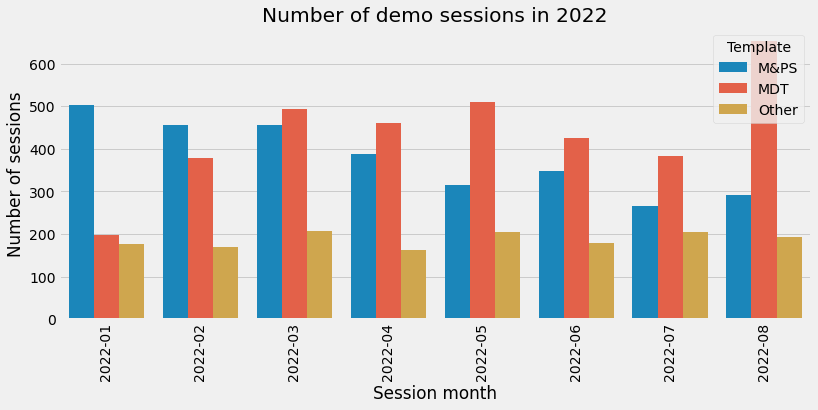

In [118]:
#number of sessions per template per time of creation of accounts in 2022
name = 'demo_sessions_per_template_with_age.png'
plt.figure(figsize = (12,5))
sns.barplot(data = sessions_by_template, x = 'Session month', y = 'SessionStart', hue = 'Template')
plt.title('Number of demo sessions in 2022')
plt.xticks(rotation = 'vertical')
plt.ylabel('Number of sessions')
plt.savefig(name, dpi = 300, bbox_inches = 'tight')
plt.show()

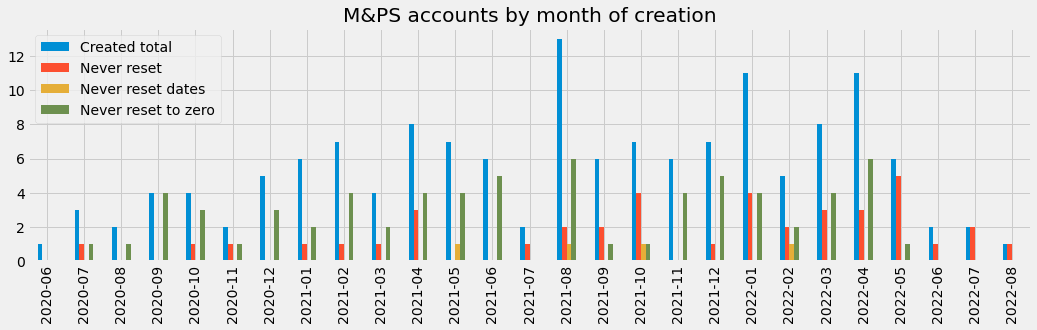

In [78]:
#mps accounts by month of creation with indicators of resets
name = 'active_mps_accounts_resets.png'
active_accs_all_resets_mps.plot(kind = 'bar', figsize = (16,4))
plt.xticks(ticks = np.arange(len(active_accs_all_resets_mps)), labels = active_accs_all_resets_mps['Created month'], rotation = 'vertical')
plt.title('M&PS accounts by month of creation')
plt.savefig(name, dpi = 300, bbox_inches = 'tight')
plt.show()

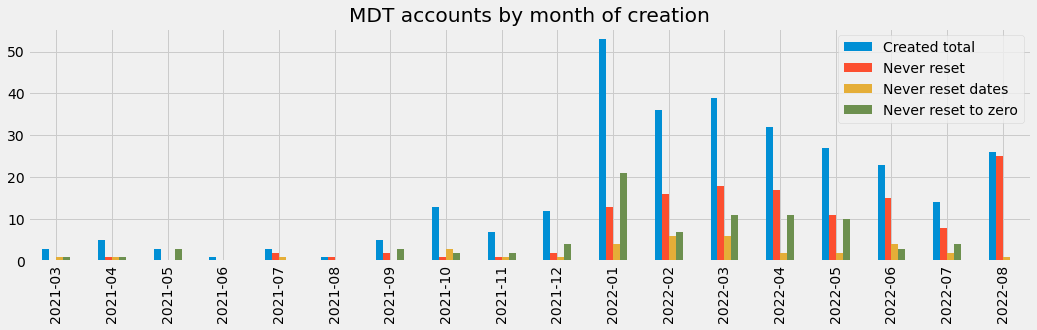

In [79]:
#mdt accounts by month of creation with indicators of resets
name = 'active_mdt_accounts_resets.png'
active_accs_all_resets_mdt.plot(kind = 'bar', figsize = (16,4))
plt.xticks(ticks = np.arange(len(active_accs_all_resets_mdt)), labels = active_accs_all_resets_mdt['Created month'], rotation = 'vertical')
plt.title('MDT accounts by month of creation')
plt.savefig(name, dpi = 300, bbox_inches = 'tight')
plt.show()